In [64]:
import polars as pl 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [34]:

def gini_from_list(points):
    """Compute Gini coefficient for 1D list or array of nonnegative numbers."""
    arr = np.array(points, dtype=float)
    if arr.sum() == 0:
        return 0.0
    arr = np.sort(arr)
    n = len(arr)
    index = np.arange(1, n + 1)
    gini = (2 * np.sum(index * arr)) / (n * arr.sum()) - (n + 1) / n
    return float(gini)



data = {
    "race": ["Race1", "Race1", "Race1", "Race2", "Race2", "Race2"],
    "driver": ["A", "B", "C", "A", "B", "C"],
    "points": [25, 18, 0, 15, 15, 10]
}

df = pl.DataFrame(data)


group = df.group_by('race')
group.agg(pl.col('points')).with_columns(pl.col('points').map_elements(gini_from_list).alias('gini'))
#gini_from_list(df['points'])


C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27060\2208681776.py:24: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  group.agg(pl.col('points')).with_columns(pl.col('points').map_elements(gini_from_list))


race,points
str,f64
"""Race2""",0.083333
"""Race1""",0.387597


In [303]:
races = pl.read_csv('races.csv')

In [325]:
select_races = races.filter(pl.col('year') >= 2010)

In [326]:
select_races  = select_races.select('raceId', 'year','name')

In [327]:
results = pl.read_csv('results.csv',infer_schema_length=10000,null_values="\\N")

In [328]:
results = results.join(select_races, on= 'raceId')

In [329]:
results = results.with_columns([
    pl.col("fastestLapTime").str.split(":").alias("split")
])

# Extract minutes and seconds string
results = results.with_columns([
    pl.col("split").list.get(0).cast(pl.Int32).alias("minutes"),
    pl.col("split").list.get(1).cast(pl.Float64).alias("seconds_float")
])

# Get integer seconds and milliseconds
results = results.with_columns([
    pl.col("seconds_float").cast(pl.Int32).alias("seconds"),
    ((pl.col("seconds_float") - pl.col("seconds_float").cast(pl.Int32)) * 1000).cast(pl.Int32).alias("milliseconds")
])

# Optionally calculate total seconds as float
results = results.with_columns([
    (pl.col("minutes") * 60 + pl.col("seconds_float")).alias("total_seconds")
])

In [330]:
results

resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,name,split,minutes,seconds_float,seconds,total_seconds
i64,i64,i64,i64,i64,i64,i64,str,i64,f64,i64,str,i32,i64,i64,str,f64,i64,i64,str,list[str],i32,f64,i32,f64
20323,337,4,6,8,3,1,"""1""",1,25.0,49,"""1:39:20.396""",286,45,1,"""1:58.287""",191.706,1,2010,"""Bahrain Grand Prix""","[""1"", ""58.287""]",1,58.287,58,118.287
20324,337,13,6,7,2,2,"""2""",2,18.0,49,"""+16.099""",731,38,5,"""1:59.732""",189.392,1,2010,"""Bahrain Grand Prix""","[""1"", ""59.732""]",1,59.732,59,119.732
20325,337,1,1,2,4,3,"""3""",3,15.0,49,"""+23.182""",560,42,4,"""1:59.560""",189.665,1,2010,"""Bahrain Grand Prix""","[""1"", ""59.560""]",1,59.56,59,119.56
20326,337,20,9,5,1,4,"""4""",4,12.0,49,"""+38.799""",218,32,12,"""2:00.218""",188.627,1,2010,"""Bahrain Grand Prix""","[""2"", ""00.218""]",2,0.218,0,120.218
20327,337,3,131,4,5,5,"""5""",5,10.0,49,"""+40.213""",236,45,13,"""2:00.236""",188.599,1,2010,"""Bahrain Grand Prix""","[""2"", ""00.236""]",2,0.236,0,120.236
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
26760,1144,825,210,20,14,16,"""16""",16,0.0,57,null,637,57,1,"""1:25.637""",222.002,11,2024,"""Abu Dhabi Grand Prix""","[""1"", ""25.637""]",1,25.637,25,85.637
26761,1144,859,215,30,12,17,"""17""",17,0.0,55,null,751,52,12,"""1:28.751""",214.212,5,2024,"""Abu Dhabi Grand Prix""","[""1"", ""28.751""]",1,28.751,28,88.751
26762,1144,822,15,77,9,null,"""R""",18,0.0,30,null,481,14,19,"""1:29.482""",212.462,130,2024,"""Abu Dhabi Grand Prix""","[""1"", ""29.482""]",1,29.482,29,89.482


In [320]:
years = results.group_by('year','constructorId','driverId').agg(pl.col('points').sum())

In [331]:
results = results.with_columns(
    pl.count('points').over(['year', 'driverId']).alias('race_count')
).filter(
    pl.col('race_count') > 10
).drop('race_count')

In [289]:
year_gini = years.group_by('year').agg(pl.col('points')).with_columns(pl.col('points').map_elements(gini_from_list).alias('gini'))

C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27060\3456589746.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  year_gini = years.group_by('year').agg(pl.col('points')).with_columns(pl.col('points').map_elements(gini_from_list).alias('gini'))


<AxesSubplot:xlabel='year', ylabel='gini'>

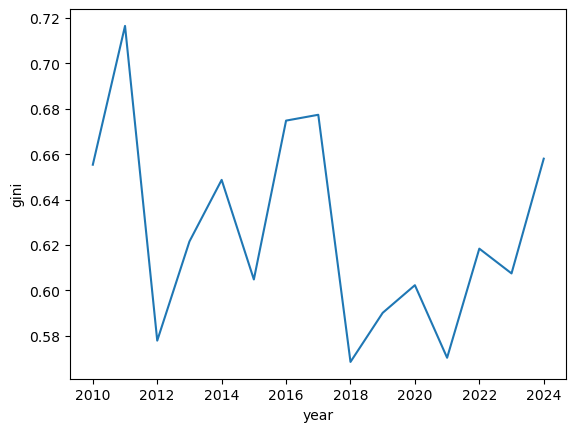

In [290]:
sns.lineplot(x=year_gini['year'], y=year_gini['gini'])

In [291]:
teams = results.group_by('year','constructorId','driverId').agg(pl.col('points').sum())

In [292]:
team_gini = teams.group_by('year','constructorId').agg(pl.col('points')).with_columns(pl.col('points').map_elements(gini_from_list).alias('gini'))

C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27060\2434831050.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  team_gini = teams.group_by('year','constructorId').agg(pl.col('points')).with_columns(pl.col('points').map_elements(gini_from_list).alias('gini'))


In [293]:
team_gini = team_gini.with_columns(pl.col('gini').mean().over('year').alias('year_gini'))

<AxesSubplot:xlabel='year', ylabel='year_gini'>

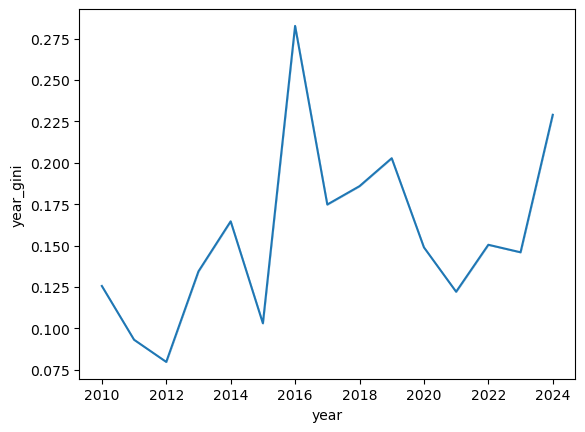

In [294]:
sns.lineplot(x=team_gini['year'], y=team_gini['year_gini'])

In [72]:
results.group_by('constructorId', 'year').agg(pl.col('driverId').unique().len())

constructorId,year,driverId
i64,i64,u32
207,2014,4
6,2013,2
207,2012,2
15,2018,2
1,2018,2
…,…,…
1,2013,2
131,2018,2
5,2017,4


C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27060\2847320766.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  driver_gini = results.group_by('year','constructorId','driverId').agg(pl.col('points')).with_columns(pl.col('points').map_elements(gini_from_list).alias('gini'))


<AxesSubplot:xlabel='year', ylabel='gini'>

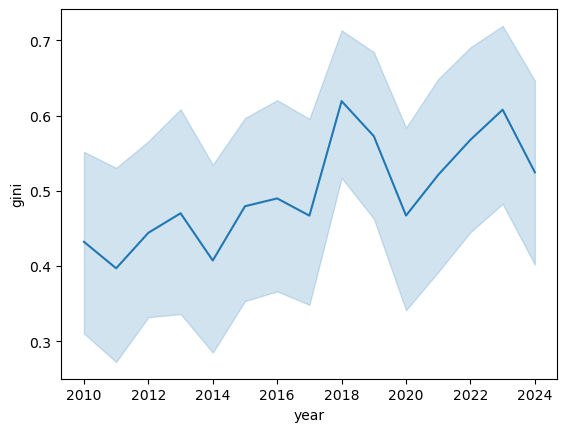

In [119]:
drivers = results.group_by('year','constructorId','driverId').agg(pl.col('points'))
driver_gini = results.group_by('year','constructorId','driverId').agg(pl.col('points')).with_columns(pl.col('points').map_elements(gini_from_list).alias('gini'))

sns.lineplot(x=driver_gini['year'], y=driver_gini['gini'])

# Lap Time Gini

In [128]:
results['fastestLapTime']

fastestLapTime
str
"""1:58.287"""
"""1:59.732"""
"""1:59.560"""
"""2:00.218"""
"""2:00.236"""
…
"""1:25.637"""
"""1:28.751"""
"""1:29.482"""


In [190]:
time_gini = results.filter(pl.col('total_seconds').is_not_null()).group_by('year','name').agg(pl.col('total_seconds'))

In [191]:
time_gini

year,name,total_seconds
i64,str,list[f64]
2014,"""Malaysian Grand Prix""","[103.066, 103.96, … 110.929]"
2017,"""Singapore Grand Prix""","[105.008, 105.301, … 133.579]"
2015,"""Malaysian Grand Prix""","[103.648, 103.125, … 108.76]"
2023,"""Mexico City Grand Prix""","[81.644, 81.334, … 83.146]"
2011,"""Belgian Grand Prix""","[110.451, 109.883, … 116.79]"
…,…,…
2019,"""Chinese Grand Prix""","[95.892, 94.872, … 99.677]"
2018,"""Chinese Grand Prix""","[95.785, 96.987, … 99.376]"
2013,"""United States Grand Prix""","[99.856, 100.445, … 103.775]"


In [192]:
#time_gini = time_gini.filter(pl.col('total_seconds') > 0)

In [193]:
time_gini = time_gini.with_columns(pl.col('total_seconds').map_elements(gini_from_list).alias('gini'))

C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27060\440658771.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  time_gini = time_gini.with_columns(pl.col('total_seconds').map_elements(gini_from_list).alias('gini'))


In [194]:
time_gini

year,name,total_seconds,gini
i64,str,list[f64],f64
2014,"""Malaysian Grand Prix""","[103.066, 103.96, … 110.929]",0.011226
2017,"""Singapore Grand Prix""","[105.008, 105.301, … 133.579]",0.029549
2015,"""Malaysian Grand Prix""","[103.648, 103.125, … 108.76]",0.009066
2023,"""Mexico City Grand Prix""","[81.644, 81.334, … 83.146]",0.003881
2011,"""Belgian Grand Prix""","[110.451, 109.883, … 116.79]",0.012974
…,…,…,…
2019,"""Chinese Grand Prix""","[95.892, 94.872, … 99.677]",0.009125
2018,"""Chinese Grand Prix""","[95.785, 96.987, … 99.376]",0.005292
2013,"""United States Grand Prix""","[99.856, 100.445, … 103.775]",0.006348


<AxesSubplot:xlabel='year', ylabel='gini'>

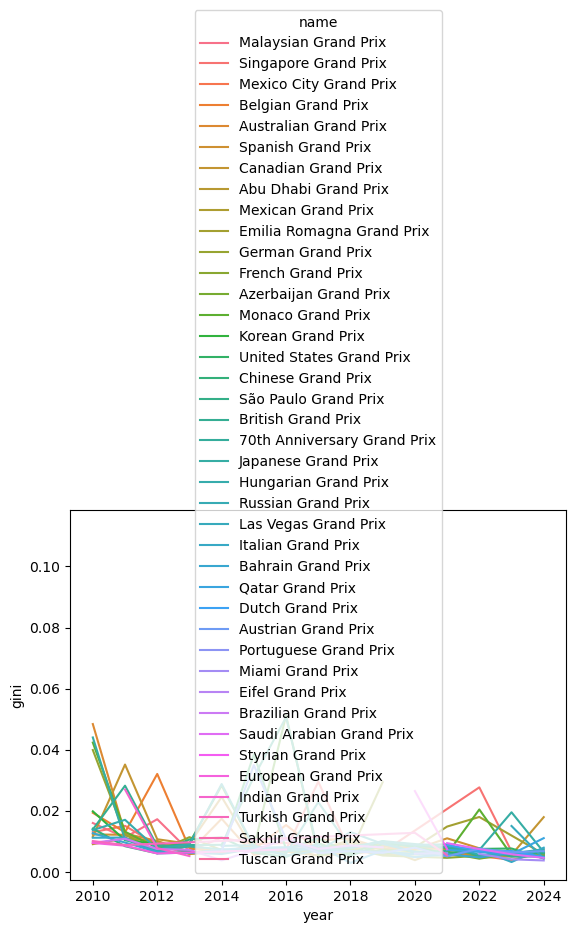

In [195]:
sns.lineplot(x=time_gini['year'], y=time_gini['gini'],hue=time_gini['name'])

In [207]:
results.describe()

statistic,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,name,split,minutes,seconds_float,seconds,total_seconds
str,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,f64,f64
"""count""",6436.0,6436.0,6436.0,6436.0,6436.0,6436.0,5397.0,"""6436""",6436.0,6436.0,6436.0,"""3310""",6151.0,6151.0,6409.0,"""6151""",6151.0,6436.0,6436.0,"""6436""",6151.0,6151.0,6151.0,6151.0,6151.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,1039.0,"""0""",0.0,0.0,0.0,"""3126""",285.0,285.0,27.0,"""285""",285.0,0.0,0.0,"""0""",285.0,285.0,285.0,285.0,285.0
"""mean""",23543.372281,942.874145,538.660193,71.013828,22.893257,10.86762,9.49194,null,11.112337,4.811762,53.260255,null,502.136563,45.280605,10.308472,null,203.561548,9.337321,2016.967993,null,null,1.004715,31.543115,31.040481,91.825996
"""std""",1860.497114,186.135383,386.444722,85.709034,21.840809,6.244851,5.341782,null,6.195216,7.135667,17.863799,null,286.355323,15.240338,6.251656,null,21.462159,20.002652,4.417761,null,null,0.102698,12.102851,12.105666,12.490303
"""min""",20323.0,337.0,1.0,1.0,1.0,0.0,1.0,"""1""",1.0,0.0,0.0,"""+0.179""",0.0,1.0,0.0,"""0:55.404""",89.54,1.0,2010.0,"""70th Anniversary Grand Prix""",null,0.0,0.025,0.0,55.404
"""25%""",21932.0,890.0,20.0,5.0,8.0,6.0,5.0,null,6.0,0.0,51.0,null,256.0,38.0,5.0,null,191.733,1.0,2013.0,null,null,1.0,21.382,21.0,81.517
"""50%""",23543.0,977.0,817.0,10.0,17.0,11.0,9.0,null,11.0,0.0,56.0,null,505.0,48.0,10.0,null,203.925,1.0,2017.0,null,null,1.0,31.721,31.0,91.862
"""75%""",25155.0,1060.0,835.0,131.0,27.0,16.0,14.0,null,16.0,8.0,66.0,null,747.0,55.0,16.0,null,217.538,11.0,2021.0,null,null,1.0,40.926,40.0,101.071
"""max""",26764.0,1144.0,862.0,215.0,99.0,24.0,24.0,"""W""",24.0,50.0,87.0,"""4:04:39.537""",999.0,85.0,24.0,"""2:56.181""",256.1,141.0,2024.0,"""United States Grand Prix""",null,2.0,59.97,59.0,176.181


In [197]:
time_gini.sort(by='gini')

year,name,total_seconds,gini
i64,str,list[f64],f64
2018,"""Bahrain Grand Prix""","[94.453, 93.74, … 94.337]",0.002936
2023,"""Italian Grand Prix""","[85.24, 85.522, … 86.963]",0.003225
2024,"""Miami Grand Prix""","[90.98, 91.261, … 93.452]",0.003742
2014,"""Brazilian Grand Prix""","[73.619, 73.555, … 75.387]",0.003776
2020,"""Abu Dhabi Grand Prix""","[100.958, 101.131, … 103.263]",0.003835
…,…,…,…
2010,"""Japanese Grand Prix""","[93.653, 93.474, … 161.378]",0.044017
2010,"""Australian Grand Prix""","[89.291, 89.57, … 147.276]",0.048398
2016,"""British Grand Prix""","[95.771, 96.407, … 168.804]",0.050632


In [199]:
time_gini.group_by('name').agg(pl.col('gini').mean()).sort(by='gini')

name,gini
str,f64
"""Miami Grand Prix""",0.004584
"""Sakhir Grand Prix""",0.004857
"""70th Anniversary Grand Prix""",0.005167
"""Mexico City Grand Prix""",0.005569
"""French Grand Prix""",0.00575
…,…
"""British Grand Prix""",0.013676
"""German Grand Prix""",0.015036
"""Monaco Grand Prix""",0.016203


# Driver vs Car Regression

In [211]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pandas as pd

In [322]:
df = pd.DataFrame(results, columns=results.columns)
df = df.dropna()
df = df[['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'rank', 
       'fastestLapSpeed', 'statusId', 'year', 'total_seconds']].apply(pd.to_numeric)
years = sorted(df['year'].unique())
results = []

for y in years:
    df_year = df[df['year'] == y].copy()
    df_year['dummy'] = 0

    model = MixedLM.from_formula(
        formula="points ~ 1",  # no year fixed effect here since single year subset
        data=df_year,
        groups="dummy",
        vc_formula={
            "driver": "0 + C(driverId)",
            "constructor": "0 + C(constructorId)"
        }
    )

    result = model.fit()

    driver_var = result.vcomp[0]
    constructor_var = result.vcomp[1]
    residual_var = result.scale
    total_var = driver_var + constructor_var + residual_var

    results.append({
        'year': y,
        'driver_var': driver_var,
        'constructor_var': constructor_var,
        'residual_var': residual_var,
        'driver_pct': driver_var / total_var * 100,
        'constructor_pct': constructor_var / total_var * 100,
        'residual_pct': residual_var / total_var * 100,
    })

df_variance_by_year = pd.DataFrame(results)
print(df_variance_by_year)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.wa

    year  driver_var  constructor_var  residual_var  driver_pct  \
0   2010   27.061056         4.298240     31.426473   43.100621   
1   2011   34.606885         6.053495     19.190715   57.821641   
2   2012   21.365697         3.425807     36.213776   35.022701   
3   2013   31.233638         6.249887     23.055086   51.592921   
4   2014   53.245809         4.679751     30.053753   60.520828   
5   2015   32.552854         2.126805     20.223234   59.291691   
6   2016   29.360286         0.102228     22.662368   56.326816   
7   2017   32.208098         1.910876     21.556344   57.849868   
8   2018   32.924372         4.264210     21.569603   56.033678   
9   2019   34.610717         2.292823     22.927880   57.847059   
10  2020   16.557556        16.331468     27.751307   27.304527   
11  2021   27.209843         6.578620     29.399937   43.061453   
12  2022   61.261868         3.706588     17.566404   74.225446   
13  2023   30.215347         8.727166     20.949223   50.44994

In [295]:
# Count races per driver per year
race_counts = df.groupby(['year', 'driverId']).size().reset_index(name='race_count')

# Filter drivers with >= 5 races
eligible = race_counts[race_counts['race_count'] > 10]

# Merge back to original df to keep only eligible drivers for each year
df = df.merge(eligible[['year', 'driverId']], on=['year', 'driverId'], how='inner')


In [296]:
driver_season_points = df.groupby(['year', 'driverId', 'constructorId'])['points'].sum().reset_index()


In [297]:
driver_season_points['dummy'] = 0

model = mixedlm(
    "points ~ year",                      # fixed effect: year only
    driver_season_points,
    groups=driver_season_points["dummy"],  # dummy grouping for overall intercept
    vc_formula={
        "driver": "0 + C(driverId)",
        "constructor": "0 + C(constructorId)"
    }
)

result = model.fit()
print(result.summary())

# Extract variance components
driver_var = result.vcomp[0]
constructor_var = result.vcomp[1]
residual_var = result.scale

total_var = driver_var + constructor_var + residual_var

print(f"Driver variance: {driver_var:.3f} ({driver_var / total_var * 100:.1f}%)")
print(f"Constructor variance: {constructor_var:.3f} ({constructor_var / total_var * 100:.1f}%)")
print(f"Residual variance: {residual_var:.3f} ({residual_var / total_var * 100:.1f}%)")

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     points   
No. Observations:     149         Method:                 REML     
No. Groups:           1           Scale:                  5067.5281
Min. group size:      149         Log-Likelihood:         -868.6747
Max. group size:      149         Converged:              Yes      
Mean group size:      149.0                                        
-------------------------------------------------------------------
                  Coef.   Std.Err.   z    P>|z|   [0.025    0.975] 
-------------------------------------------------------------------
Intercept       -4885.982 3786.153 -1.290 0.197 -12306.705 2534.741
year                2.476    1.876  1.320 0.187     -1.201    6.154
constructor Var  5856.208   39.569                                 
driver Var       1965.568   13.170                                 

Driver variance: 5856.208 (45.4%)
Constructor variance: 1965.5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [359]:
from statsmodels.regression.mixed_linear_model import MixedLM

m_results = []
# Placeholder lists for storing results
years = sorted(df['year'].unique())

for y in years:
    df_year = df[df['year'] == y].copy()

    # Add dummy group
    df_year['dummy'] = 0

    # Define formula: points ~ 1  (intercept only, since year constant per subset)
    model = MixedLM.from_formula(
        formula="points ~ 1",
        data=df_year,
        groups="dummy",
        vc_formula={
            "driver": "0 + C(driverId)",
            "constructor": "0 + C(constructorId)"
        }
    )

    result = model.fit(reml=True)

    driver_var = result.vcomp[0]
    constructor_var = result.vcomp[1]
    residual_var = result.scale
    total_var = driver_var + constructor_var + residual_var

    m_results.append({
        'year': y,
        'driver_var': driver_var,
        'constructor_var': constructor_var,
        'residual_var': residual_var,
        'driver_pct': driver_var / total_var * 100,
        'constructor_pct': constructor_var / total_var * 100,
        'residual_pct': residual_var / total_var * 100,
    })

df_variance_by_year = pd.DataFrame(m_results)
print(df_variance_by_year)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.wa

    year  driver_var  constructor_var  residual_var  driver_pct  \
0   2010   27.061056         4.298240     31.426473   43.100621   
1   2011   34.606885         6.053495     19.190715   57.821641   
2   2012   21.365697         3.425807     36.213776   35.022701   
3   2013   31.233638         6.249887     23.055086   51.592921   
4   2014   53.245809         4.679751     30.053753   60.520828   
5   2015   32.552854         2.126805     20.223234   59.291691   
6   2016   29.360286         0.102228     22.662368   56.326816   
7   2017   32.208098         1.910876     21.556344   57.849868   
8   2018   32.924372         4.264210     21.569603   56.033678   
9   2019   34.610717         2.292823     22.927880   57.847059   
10  2020   16.557556        16.331468     27.751307   27.304527   
11  2021   27.209843         6.578620     29.399937   43.061453   
12  2022   61.261868         3.706588     17.566404   74.225446   
13  2023   30.215347         8.727166     20.949223   50.44994

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.866912
  warnings.warn(msg, ConvergenceWarning)


<module 'seaborn' from 'C:\\Users\\mhbvp41\\AppData\\Roaming\\Python\\Python39\\site-packages\\seaborn\\__init__.py'>

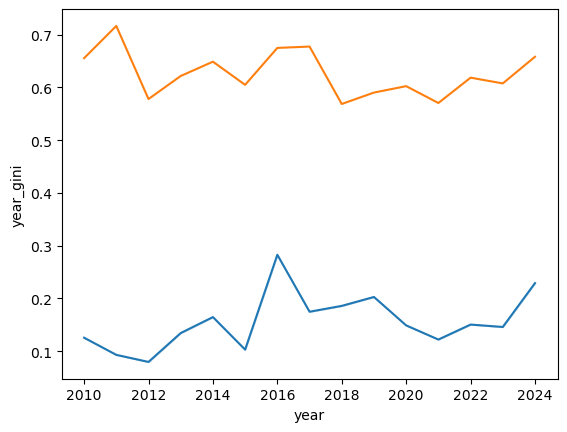

In [360]:
df_variance_by_year
sns.lineplot(x=team_gini['year'], y=team_gini['year_gini'])
sns.lineplot(x=year_gini['year'], y=year_gini['gini'])

sns

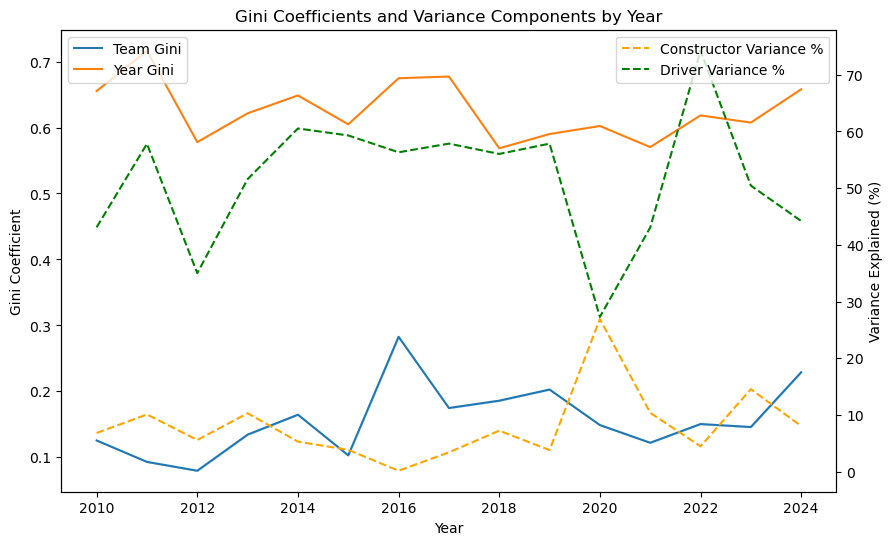

In [361]:

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot Ginis on primary y-axis
sns.lineplot(x=team_gini['year'], y=team_gini['year_gini'], ax=ax1, label='Team Gini')
sns.lineplot(x=year_gini['year'], y=year_gini['gini'], ax=ax1, label='Year Gini')

ax1.set_xlabel('Year')
ax1.set_ylabel('Gini Coefficient')
ax1.legend(loc='upper left')
ax1.set_title('Gini Coefficients and Variance Components by Year')

# Create secondary y-axis
ax2 = ax1.twinx()

# Plot variance components on secondary y-axis
sns.lineplot(x=df_variance_by_year['year'], y=df_variance_by_year['constructor_pct'], 
             ax=ax2, color='orange', label='Constructor Variance %', linestyle='--')
sns.lineplot(x=df_variance_by_year['year'], y=df_variance_by_year['driver_pct'], 
             ax=ax2, color='green', label='Driver Variance %', linestyle='--')

ax2.set_ylabel('Variance Explained (%)')
ax2.legend(loc='upper right')

plt.show()


In [301]:
df_variance_by_year

,year,driver_var,constructor_var,residual_var,driver_pct,constructor_pct,residual_pct
0,2010,11.737663,6.320202,40.254310,20.129009,10.838564,69.032427
1,2011,3.300082,16.050420,22.469744,7.891110,38.379545,53.729345
2,2012,19.608841,4.821810,36.687463,32.083517,7.889331,60.027152
3,2013,18.926866,11.522698,29.175765,31.742997,19.325173,48.931831
4,2014,32.353200,6.495606,34.932196,43.850313,8.803900,47.345787
5,2015,27.557880,3.667422,23.347093,50.497838,6.720288,42.781874
6,2016,22.732784,0.051284,26.151030,46.454968,0.104800,53.440231
7,2017,23.553259,4.237889,25.973683,43.807929,7.882271,48.309800
8,2018,16.323242,9.236392,28.455439,30.219790,17.099658,52.680552
9,2019,24.307724,5.671856,28.198986,41.781236,9.749047,48.469716


# Lap Time Regression

In [343]:
times_years = results.group_by('year','constructorId','driverId').agg(pl.col('total_seconds').median())
times_year_gini = times_years.group_by('year').agg(pl.col('total_seconds')).with_columns(pl.col('total_seconds').map_elements(gini_from_list).alias('gini'))


times_team_gini = times_years.group_by('year','constructorId').agg(pl.col('total_seconds')).with_columns(pl.col('total_seconds').map_elements(gini_from_list).alias('gini'))

C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27060\481722697.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  times_year_gini = times_years.group_by('year').agg(pl.col('total_seconds')).with_columns(pl.col('total_seconds').map_elements(gini_from_list).alias('gini'))
C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27060\481722697.py:5: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  times_team_gini = times_years.group_by('year','constructorId').agg(pl.col('total_seconds')).with_columns(pl.col('total_seconds').map_elements(gini_from_list).alias('gini'))


In [431]:
df = pd.DataFrame(results, columns=results.columns)
df = df.dropna()
df = df[['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'rank', 
       'fastestLapSpeed', 'statusId', 'year', 'total_seconds']].apply(pd.to_numeric)


driver_season_times = df.groupby(['year', 'driverId'])['total_seconds'].median().reset_index()


In [355]:
from statsmodels.regression.mixed_linear_model import MixedLM

m_results = []
# Placeholder lists for storing results
years = sorted(df['year'].unique())

for y in years:
    df_year = driver_season_times[driver_season_times['year'] == y].copy()

    # Add dummy group
    df_year['dummy'] = 0

    # Define formula: points ~ 1  (intercept only, since year constant per subset)
    model = MixedLM.from_formula(
        formula="total_seconds ~ 1",
        data=df_year,
        groups="dummy",
        vc_formula={
            "driver": "0 + C(driverId)",
            "constructor": "0 + C(constructorId)"
        }
    )

    result = model.fit(reml=True)

    driver_var = result.vcomp[0]
    constructor_var = result.vcomp[1]
    residual_var = result.scale
    total_var = driver_var + constructor_var + residual_var

    m_results.append({
        'year': y,
        'driver_var': driver_var,
        'constructor_var': constructor_var,
        'residual_var': residual_var,
        'driver_pct': driver_var / total_var * 100,
        'constructor_pct': constructor_var / total_var * 100,
        'residual_pct': residual_var / total_var * 100,
    })

df_variance_by_year = pd.DataFrame(m_results)
print(df_variance_by_year)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


    year    driver_var  constructor_var  residual_var    driver_pct  \
0   2010  9.012385e+00         1.536448      3.494898  6.417372e+01   
1   2011  9.100484e+00         0.923951      2.746598  7.125879e+01   
2   2012  3.019787e+01         0.432387      5.434163  8.373314e+01   
3   2013  3.108586e+00         1.213071      1.771365  5.101879e+01   
4   2014  1.084379e+01        15.194824     13.684278  2.729860e+01   
5   2015  2.130504e-08        16.588081      8.431020  8.515510e-08   
6   2016  6.055956e+00        20.937159      3.887356  1.961096e+01   
7   2017  1.538308e+01        55.069854      0.094404  2.180533e+01   
8   2018  1.656812e+00         5.211975      3.863929  1.543703e+01   
9   2019  5.983534e+00         0.827889     42.610692  1.210700e+01   
10  2020  1.399262e+01         3.904092     39.639838  2.431954e+01   
11  2021  2.826857e+01         2.774224      8.423548  7.162703e+01   
12  2022  9.692877e+00         1.289604      3.254724  6.808132e+01   
13  20

In [339]:
times_team_gini

NameError: name 'times_team_gini' is not defined

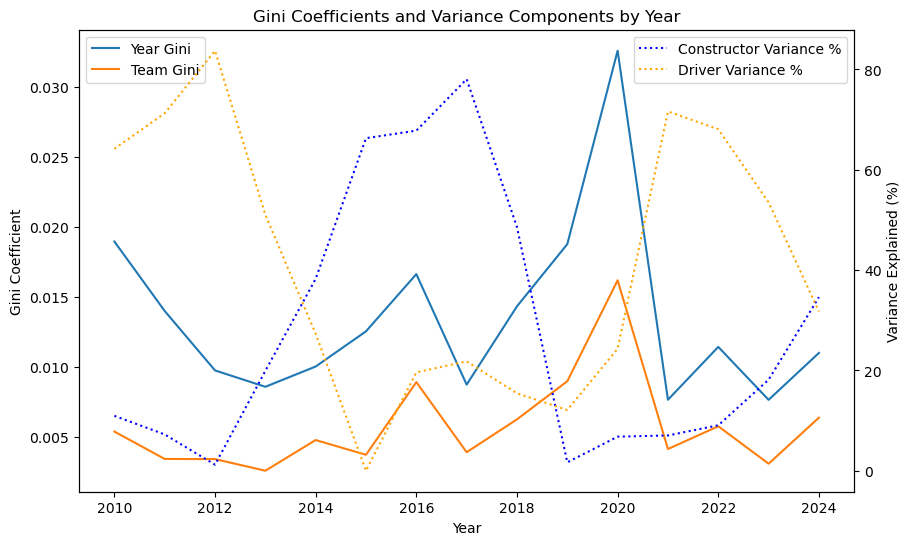

In [356]:

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot Ginis on primary y-axis
sns.lineplot(x=times_year_gini['year'], y=times_year_gini['gini'], ax=ax1, label='Year Gini')
sns.lineplot(x=times_team_gini['year'], y=times_team_gini['gini'], ax=ax1, label='Team Gini', errorbar=None)


ax1.set_xlabel('Year')
ax1.set_ylabel('Gini Coefficient')
ax1.legend(loc='upper left')
ax1.set_title('Gini Coefficients and Variance Components by Year')

# Create secondary y-axis
ax2 = ax1.twinx()

# Plot variance components on secondary y-axis
sns.lineplot(x=df_variance_by_year['year'], y=df_variance_by_year['constructor_pct'], 
             ax=ax2, color='blue', label='Constructor Variance %', linestyle=':')
sns.lineplot(x=df_variance_by_year['year'], y=df_variance_by_year['driver_pct'], 
             ax=ax2, color='orange', label='Driver Variance %', linestyle=':')

ax2.set_ylabel('Variance Explained (%)')
ax2.legend(loc='upper right')

plt.show()

In [362]:
0.02 * 90

1.8

In [380]:
times_range = pl.DataFrame(driver_season_times).group_by('year').agg(pl.col('total_seconds').quantile(.8) - pl.col('total_seconds').quantile(.2))
viz = times_range.group_by('year').agg(pl.col('total_seconds').mean())
sns.lineplot(x=viz['year'], y=viz['total_seconds'],label='Gap 80th to 20th Percentile')

In [382]:
viz = times_range.group_by('year').agg(pl.col('total_seconds').mean())

<AxesSubplot:xlabel='year', ylabel='total_seconds'>

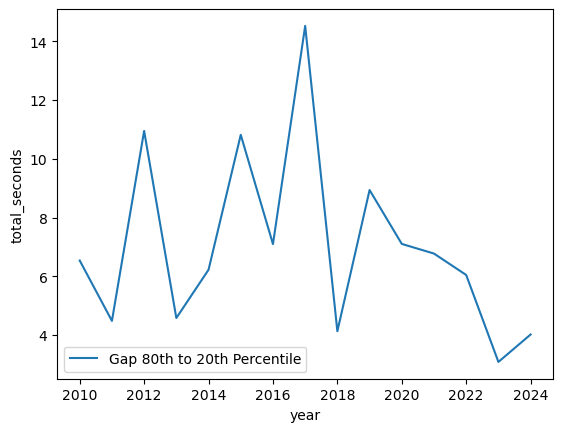

In [385]:
sns.lineplot(x=viz['year'], y=viz['total_seconds'],label='Gap 80th to 20th Percentile')

<AxesSubplot:xlabel='year', ylabel='total_seconds'>

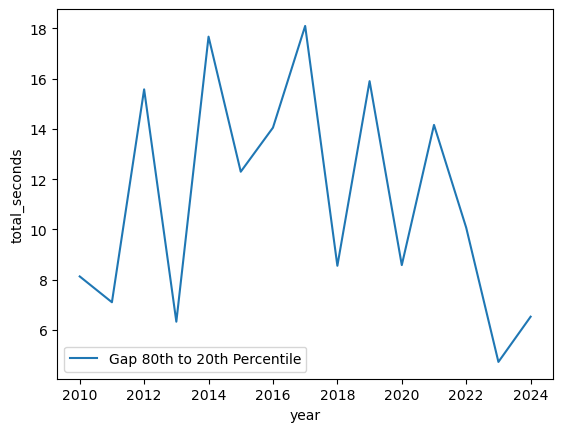

In [386]:
times_range = pl.DataFrame(driver_season_times).group_by('year').agg(pl.col('total_seconds').quantile(.9) - pl.col('total_seconds').quantile(.1))
viz = times_range.group_by('year').agg(pl.col('total_seconds').mean())
sns.lineplot(x=viz['year'], y=viz['total_seconds'],label='Gap 80th to 20th Percentile')

In [389]:
times_range

year,total_seconds
i64,f64
2013,2.572
2010,3.737
2023,2.3225
2017,10.225
2012,10.6655
…,…
2020,2.7995
2018,2.586
2014,12.9795


<AxesSubplot:xlabel='year', ylabel='total_seconds'>

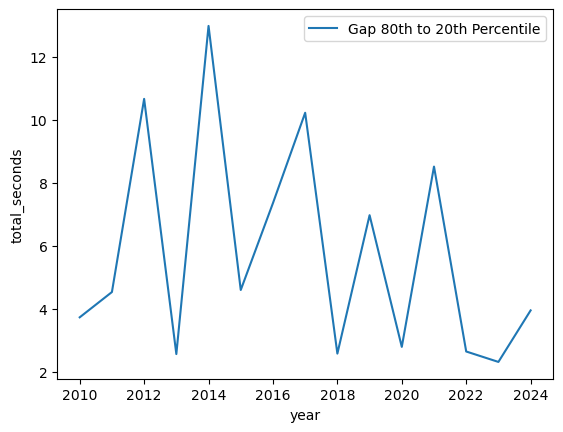

In [388]:
times_range = pl.DataFrame(driver_season_times).group_by('year').agg(pl.col('total_seconds').quantile(.90) - pl.col('total_seconds').quantile(.50))
viz = times_range.group_by('year').agg(pl.col('total_seconds').mean())
sns.lineplot(x=viz['year'], y=viz['total_seconds'],label='Gap 80th to 20th Percentile')

In [468]:
driver_season_times =results.group_by(['year', 'driverId','name']).agg(pl.col('total_seconds').median())


In [537]:
def lap_gaps_year(per,df):
    df = df.with_columns((100*(pl.col('total_seconds').quantile(.90).over('year','name') - pl.col('total_seconds').quantile(per).over('year','name')) /  pl.col('total_seconds').quantile(.90).over('year','name') ).alias(f'Gap 90th To {int(100 *per)}th Percentile'))
    return df
                                                        
                                                        
gaps = [.90,.80,.70,.60,.50,.40,.30,.20,.10]

example = pl.DataFrame(driver_season_times)
for gap in gaps:
    example = lap_gaps_year(gap,example)
    


In [538]:
year_ex= example.melt(
    id_vars=['year','name'],  # Include other columns you want to keep (e.g., ['year', 'race'] if they exist)
    value_vars=[
        "Gap 90th To 80th Percentile",
        "Gap 90th To 70th Percentile",
        "Gap 90th To 60th Percentile",
        "Gap 90th To 50th Percentile",
        "Gap 90th To 40th Percentile",
        "Gap 90th To 30th Percentile",
        "Gap 90th To 20th Percentile",
        "Gap 90th To 10th Percentile"
    ],
    variable_name="Gap",
    value_name="values"
)

C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27060\3691254967.py:1: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  year_ex= example.melt(


In [539]:
year_ex = year_ex.group_by('year','Gap').agg(pl.col('values').mean())

In [541]:
year_ex = year_ex.sort(by=['year','values'])

Text(54.845538194444444, 0.5, '% Time Off')

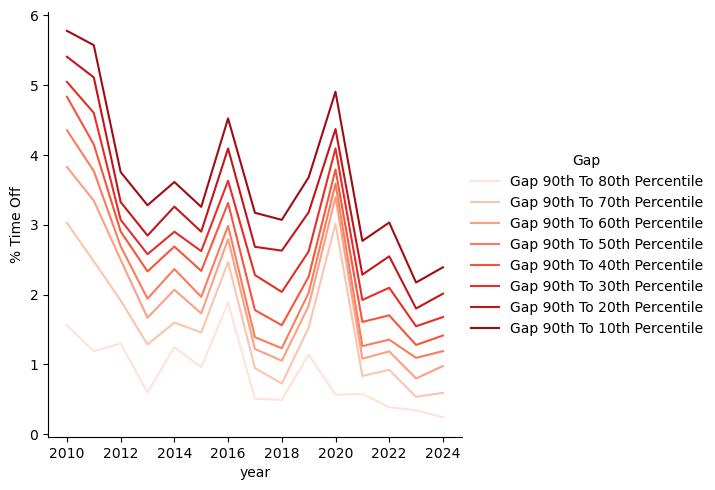

In [542]:
sns.relplot(
    data=pd.DataFrame(year_ex, columns=year_ex.columns),
    x='year', 
    y='values', 
    hue='Gap', 
    kind='line',
    palette='Reds'
)

plt.ylabel('% Time Off')

In [474]:
def lap_gaps(per,df):
    df = df.with_columns((pl.col('total_seconds').quantile(.95).over('year','name') - pl.col('total_seconds').quantile(per).over('year','name')).alias(f'Gap 95th To {per}th Percentile'),pl.col('name'))
    return df
                                                        
                                                        
gaps = [.90,.80,.70,.60,.50,.40,.30,.20,.10]

example = pl.DataFrame(driver_season_times)
for gap in gaps:
    example = lap_gaps(gap,example)

In [475]:
example

year,driverId,name,total_seconds,Gap 95th To 0.9th Percentile,Gap 95th To 0.8th Percentile,Gap 95th To 0.7th Percentile,Gap 95th To 0.6th Percentile,Gap 95th To 0.5th Percentile,Gap 95th To 0.4th Percentile,Gap 95th To 0.3th Percentile,Gap 95th To 0.2th Percentile,Gap 95th To 0.1th Percentile
i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2014,4,"""Japanese Grand Prix""",null,0.232,0.613,1.283,1.882,2.423,2.475,3.171,3.559,4.07
2013,3,"""Belgian Grand Prix""",111.582,0.03,0.929,1.452,1.859,2.345,2.742,3.328,3.527,3.957
2020,822,"""70th Anniversary Grand Prix""",89.765,0.07,0.658,0.949,1.041,1.128,1.27,1.734,1.876,2.349
2011,155,"""Abu Dhabi Grand Prix""",103.521,0.968,1.798,2.632,4.533,4.676,5.122,5.249,5.569,5.781
2024,815,"""Qatar Grand Prix""",85.288,0.377,0.585,0.856,1.885,2.279,2.477,2.679,2.902,2.926
…,…,…,…,…,…,…,…,…,…,…,…,…
2021,849,"""Saudi Arabian Grand Prix""",92.751,0.087,2.1,3.326,3.379,3.414,3.833,4.279,4.497,4.642
2023,840,"""Austrian Grand Prix""",68.463,0.236,0.379,0.39,0.565,0.893,1.068,1.296,1.356,1.713
2021,853,"""Saudi Arabian Grand Prix""",97.043,0.087,2.1,3.326,3.379,3.414,3.833,4.279,4.497,4.642


In [476]:
example = example.select(example.columns[4:14] + ['year'] + ['name'])

In [477]:
example

Gap 95th To 0.9th Percentile,Gap 95th To 0.8th Percentile,Gap 95th To 0.7th Percentile,Gap 95th To 0.6th Percentile,Gap 95th To 0.5th Percentile,Gap 95th To 0.4th Percentile,Gap 95th To 0.3th Percentile,Gap 95th To 0.2th Percentile,Gap 95th To 0.1th Percentile,year,name
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str
0.232,0.613,1.283,1.882,2.423,2.475,3.171,3.559,4.07,2014,"""Japanese Grand Prix"""
0.03,0.929,1.452,1.859,2.345,2.742,3.328,3.527,3.957,2013,"""Belgian Grand Prix"""
0.07,0.658,0.949,1.041,1.128,1.27,1.734,1.876,2.349,2020,"""70th Anniversary Grand Prix"""
0.968,1.798,2.632,4.533,4.676,5.122,5.249,5.569,5.781,2011,"""Abu Dhabi Grand Prix"""
0.377,0.585,0.856,1.885,2.279,2.477,2.679,2.902,2.926,2024,"""Qatar Grand Prix"""
…,…,…,…,…,…,…,…,…,…,…
0.087,2.1,3.326,3.379,3.414,3.833,4.279,4.497,4.642,2021,"""Saudi Arabian Grand Prix"""
0.236,0.379,0.39,0.565,0.893,1.068,1.296,1.356,1.713,2023,"""Austrian Grand Prix"""
0.087,2.1,3.326,3.379,3.414,3.833,4.279,4.497,4.642,2021,"""Saudi Arabian Grand Prix"""


In [478]:
viz2 = example.melt(
    id_vars=['year','name'],  # Include other columns you want to keep (e.g., ['year', 'race'] if they exist)
    value_vars=[
        "Gap 95th To 0.9th Percentile", 
        "Gap 95th To 0.8th Percentile",
        "Gap 95th To 0.7th Percentile",
        "Gap 95th To 0.6th Percentile",
        "Gap 95th To 0.5th Percentile",
        "Gap 95th To 0.4th Percentile",
        "Gap 95th To 0.3th Percentile",
        "Gap 95th To 0.2th Percentile",
        "Gap 95th To 0.1th Percentile"
    ],
    variable_name="Gap",
    value_name="values"
)

C:\Users\mhbvp41\AppData\Local\Temp\1\ipykernel_27060\3943282689.py:1: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  viz2 = example.melt(


In [479]:
viz2

year,name,Gap,values
i64,str,str,f64
2014,"""Japanese Grand Prix""","""Gap 95th To 0.9th Percentile""",0.232
2013,"""Belgian Grand Prix""","""Gap 95th To 0.9th Percentile""",0.03
2020,"""70th Anniversary Grand Prix""","""Gap 95th To 0.9th Percentile""",0.07
2011,"""Abu Dhabi Grand Prix""","""Gap 95th To 0.9th Percentile""",0.968
2024,"""Qatar Grand Prix""","""Gap 95th To 0.9th Percentile""",0.377
…,…,…,…
2021,"""Saudi Arabian Grand Prix""","""Gap 95th To 0.1th Percentile""",4.642
2023,"""Austrian Grand Prix""","""Gap 95th To 0.1th Percentile""",1.713
2021,"""Saudi Arabian Grand Prix""","""Gap 95th To 0.1th Percentile""",4.642


In [491]:
viz2 = viz2.with_columns(pl.col('year').cast(pl.Int64))
viz2 = viz2.with_columns(pl.col('values').cast(pl.Float64))

In [504]:
viz2.filter(pl.col('name') =='Qatar Grand Prix')

year,name,Gap,values
i64,str,str,f64
2024,"""Qatar Grand Prix""","""Gap 95th To 0.9th Percentile""",0.377
2023,"""Qatar Grand Prix""","""Gap 95th To 0.9th Percentile""",0.107
2021,"""Qatar Grand Prix""","""Gap 95th To 0.9th Percentile""",0.589
2021,"""Qatar Grand Prix""","""Gap 95th To 0.9th Percentile""",0.589
2021,"""Qatar Grand Prix""","""Gap 95th To 0.9th Percentile""",0.589
…,…,…,…
2021,"""Qatar Grand Prix""","""Gap 95th To 0.1th Percentile""",2.799
2023,"""Qatar Grand Prix""","""Gap 95th To 0.1th Percentile""",2.253
2021,"""Qatar Grand Prix""","""Gap 95th To 0.1th Percentile""",2.799


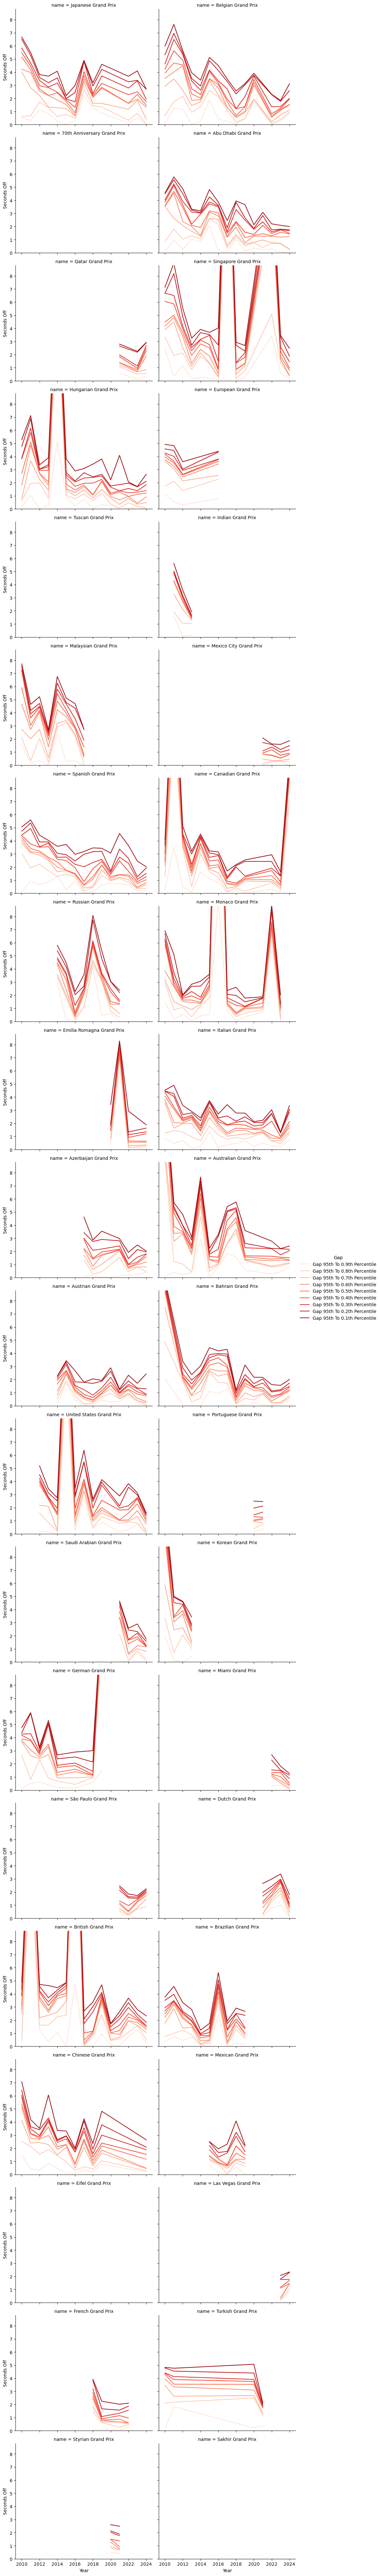

In [517]:
g = sns.relplot(
    data=pd.DataFrame(viz2, columns=viz2.columns),
    x='year', 
    y='values', 
    hue='Gap', 
    col='name',
    kind='line',
    palette='Reds',
    col_wrap=2,
    height=4,
    aspect=1.2
)

# Fix x-axis labels for all subplots
g.set_axis_labels('Year', 'Seconds Off')

# Set y-limits
g.set(ylim=(0, 8 * 1.1))
# Method 1: Using FacetGrid's set method with tick parameters
g.set(xticks=years[::2])  # This should work for FacetGrid
g.set_xticklabels(years[::2], rotation=0)



